In [11]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)


**GOAL :**
* Vanilla Deep NN 
* Code the attack : Fast gradient signed attackFGSM
* **Objective** : add the least amount of perturbation to the input data to cause the desired misclassification

Two assumptions : 
* white box: full access to model, architecture, inputs, outputs, and weights
* black box :  attacker only has access to the inputs and outputs of the model

> FOCUS ON WHIT BOX ASSUMPTION

# Implementation 

## Model

In [2]:
!wget -N https://s3.amazonaws.com/pytorch-tutorial-assets/lenet_mnist_model.pth 

--2021-03-25 22:07:02--  https://s3.amazonaws.com/pytorch-tutorial-assets/lenet_mnist_model.pth
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.251.126
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.251.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88724 (87K) [binary/octet-stream]
Saving to: ‘lenet_mnist_model.pth’

lenet_mnist_model.p 100%[===================>]  86.64K   526KB/s    in 0.2s    

2021-03-25 22:07:02 (526 KB/s) - ‘lenet_mnist_model.pth’ saved [88724/88724]



In [4]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "lenet_mnist_model.pth"
use_cuda=False 

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        ## Ghir f training 
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Init the network
model = Net().to(device)

# Load pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...


/opt/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370124688/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!
CUDA Available:  False






Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
for d ,t in test_loader

## FGSM attack 

$ pimage= x +  \epsilon * sign(\nabla_{x} J(\theta,x,y))$

where $\epsilon$ : how much we perturbe image $x$
 


In [9]:
def fgsm_attack(image, epsilon, data_grad):
    #  Sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Add grad *epsilon to pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Clip to  [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [12]:
def test(model, device, test_loader, epsilon):
    correct = 0
    adv_examples = []
    # Loop over  test set
    loop = tqdm(test_loader)
    
    for data, target in loop:
        # Utile ila kan 3anna GPU
        data, target = data.to(device), target.to(device)
        # requires_grad attribute of Data tensor.
        #  !/! Important for Attack
        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] #index of the max log-probability

        if init_pred.item() != target.item():
            print("Asslane ghalet hada")
            continue

        # Calculate negative log likelihood loss used
        loss = F.nll_loss(output, target) 
        model.zero_grad()
        
        # Backward pass
        loss.backward()

        ## FGSM Attack
        # Collect datagrad
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Predict perturbed image class
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        if final_pred.item() == target.item(): # Nothing changed ( model has good defense)
            correct += 1
        else:
            #  Save au Max 5 adv exemples
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    final_acc = correct / float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc, adv_examples

In [19]:
accuracies = []
examples = []
epsilons =[0.1,0.3,0.5,0.7]

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)


  1%|          | 92/10000 [00:00<01:39, 99.15it/s]

Asslane ghalet hada


  1%|▏         | 144/10000 [00:01<01:37, 101.05it/s]

Asslane ghalet hada
Asslane ghalet hada


  3%|▎         | 276/10000 [00:02<01:35, 101.69it/s]

Asslane ghalet hada
Asslane ghalet hada


  3%|▎         | 298/10000 [00:03<01:38, 98.66it/s] 

Asslane ghalet hada
Asslane ghalet hada


  4%|▍         | 385/10000 [00:03<01:33, 103.11it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


  4%|▍         | 430/10000 [00:04<01:33, 101.87it/s]

Asslane ghalet hada


  5%|▍         | 452/10000 [00:04<01:38, 97.40it/s] 

Asslane ghalet hada


  5%|▍         | 483/10000 [00:04<01:40, 94.52it/s]

Asslane ghalet hada


  5%|▌         | 524/10000 [00:05<01:40, 93.84it/s]

Asslane ghalet hada


  5%|▌         | 544/10000 [00:05<01:48, 87.13it/s]

Asslane ghalet hada


  8%|▊         | 767/10000 [00:08<01:42, 89.82it/s]

Asslane ghalet hada


  8%|▊         | 797/10000 [00:08<01:39, 92.22it/s]

Asslane ghalet hada


  8%|▊         | 818/10000 [00:08<01:37, 93.84it/s]

Asslane ghalet hada
Asslane ghalet hada


  8%|▊         | 849/10000 [00:09<01:37, 93.66it/s]

Asslane ghalet hada


  9%|▉         | 899/10000 [00:09<01:38, 92.62it/s]

Asslane ghalet hada


 10%|█         | 1003/10000 [00:10<01:31, 98.45it/s]

Asslane ghalet hada


 10%|█         | 1036/10000 [00:11<01:30, 99.48it/s] 

Asslane ghalet hada
Asslane ghalet hada


 11%|█         | 1080/10000 [00:11<01:31, 96.97it/s]

Asslane ghalet hada
Asslane ghalet hada


 12%|█▏        | 1150/10000 [00:12<01:40, 88.24it/s]

Asslane ghalet hada
Asslane ghalet hada


 12%|█▏        | 1211/10000 [00:13<01:35, 91.61it/s]

Asslane ghalet hada


 13%|█▎        | 1347/10000 [00:14<01:29, 97.13it/s]

Asslane ghalet hada


 14%|█▍        | 1426/10000 [00:15<01:38, 86.79it/s]

Asslane ghalet hada


 15%|█▍        | 1455/10000 [00:15<01:34, 90.27it/s]

Asslane ghalet hada


 16%|█▌        | 1585/10000 [00:17<01:30, 92.96it/s]

Asslane ghalet hada


 16%|█▌        | 1616/10000 [00:17<01:25, 97.57it/s]

Asslane ghalet hada


 17%|█▋        | 1690/10000 [00:18<01:43, 80.48it/s]

Asslane ghalet hada
Asslane ghalet hada


 17%|█▋        | 1719/10000 [00:18<01:44, 78.93it/s]

Asslane ghalet hada


 17%|█▋        | 1749/10000 [00:19<01:32, 89.30it/s]

Asslane ghalet hada


 18%|█▊        | 1779/10000 [00:19<01:31, 90.24it/s]

Asslane ghalet hada


 18%|█▊        | 1809/10000 [00:19<01:32, 88.21it/s]

Asslane ghalet hada


 18%|█▊        | 1836/10000 [00:20<01:37, 83.95it/s]

Asslane ghalet hada


 19%|█▊        | 1874/10000 [00:20<01:32, 87.72it/s]

Asslane ghalet hada
Asslane ghalet hada


 19%|█▉        | 1901/10000 [00:20<01:34, 85.50it/s]

Asslane ghalet hada


 20%|█▉        | 1950/10000 [00:21<01:32, 86.78it/s]

Asslane ghalet hada


 20%|█▉        | 1969/10000 [00:21<01:30, 88.95it/s]

Asslane ghalet hada
Asslane ghalet hada


 20%|██        | 2006/10000 [00:22<01:32, 86.68it/s]

Asslane ghalet hada


 20%|██        | 2044/10000 [00:22<01:33, 85.27it/s]

Asslane ghalet hada


 21%|██        | 2112/10000 [00:23<01:24, 93.83it/s]

Asslane ghalet hada
Asslane ghalet hada


 23%|██▎       | 2279/10000 [00:25<01:16, 100.39it/s]

Asslane ghalet hada


 23%|██▎       | 2311/10000 [00:25<01:17, 98.64it/s] 

Asslane ghalet hada


 25%|██▍       | 2451/10000 [00:26<01:12, 104.28it/s]

Asslane ghalet hada


 25%|██▍       | 2473/10000 [00:27<01:15, 100.17it/s]

Asslane ghalet hada
Asslane ghalet hada


 26%|██▋       | 2635/10000 [00:28<01:12, 101.70it/s]

Asslane ghalet hada


 30%|██▉       | 2985/10000 [00:32<01:07, 104.48it/s]

Asslane ghalet hada


 30%|███       | 3039/10000 [00:32<01:10, 99.42it/s] 

Asslane ghalet hada
Asslane ghalet hada


 31%|███       | 3112/10000 [00:33<01:11, 96.75it/s]

Asslane ghalet hada


 32%|███▏      | 3225/10000 [00:34<01:15, 89.94it/s]

Asslane ghalet hada
Asslane ghalet hada


 33%|███▎      | 3265/10000 [00:35<01:13, 91.31it/s]

Asslane ghalet hada


 33%|███▎      | 3297/10000 [00:35<01:07, 99.05it/s]

Asslane ghalet hada
Asslane ghalet hada


 34%|███▎      | 3372/10000 [00:36<01:05, 101.08it/s]

Asslane ghalet hada


 34%|███▍      | 3428/10000 [00:36<01:03, 103.78it/s]

Asslane ghalet hada


 34%|███▍      | 3450/10000 [00:37<01:05, 100.61it/s]

Asslane ghalet hada
Asslane ghalet hada


 36%|███▌      | 3615/10000 [00:38<01:01, 103.75it/s]

Asslane ghalet hada


 37%|███▋      | 3703/10000 [00:39<01:02, 101.23it/s]

Asslane ghalet hada


 37%|███▋      | 3725/10000 [00:39<01:01, 101.40it/s]

Asslane ghalet hada


 38%|███▊      | 3769/10000 [00:40<01:00, 103.55it/s]

Asslane ghalet hada


 38%|███▊      | 3812/10000 [00:40<01:03, 97.58it/s] 

Asslane ghalet hada


 39%|███▊      | 3854/10000 [00:40<01:02, 98.79it/s] 

Asslane ghalet hada


 39%|███▉      | 3909/10000 [00:41<00:59, 102.42it/s]

Asslane ghalet hada


 41%|████      | 4067/10000 [00:43<01:01, 96.27it/s] 

Asslane ghalet hada
Asslane ghalet hada


 41%|████      | 4120/10000 [00:43<00:58, 100.45it/s]

Asslane ghalet hada
Asslane ghalet hada


 42%|████▏     | 4176/10000 [00:44<00:59, 97.97it/s] 

Asslane ghalet hada


 42%|████▏     | 4208/10000 [00:44<00:57, 101.50it/s]

Asslane ghalet hada
Asslane ghalet hada


 43%|████▎     | 4275/10000 [00:45<00:55, 103.70it/s]

Asslane ghalet hada


 44%|████▎     | 4368/10000 [00:46<00:58, 95.71it/s] 

Asslane ghalet hada


 45%|████▍     | 4464/10000 [00:47<00:54, 102.00it/s]

Asslane ghalet hada
Asslane ghalet hada


 45%|████▍     | 4487/10000 [00:47<00:52, 105.73it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


 45%|████▌     | 4543/10000 [00:47<00:53, 101.34it/s]

Asslane ghalet hada
Asslane ghalet hada


 46%|████▌     | 4576/10000 [00:48<00:52, 103.13it/s]

Asslane ghalet hada


 46%|████▌     | 4609/10000 [00:48<00:52, 103.63it/s]

Asslane ghalet hada


 47%|████▋     | 4653/10000 [00:49<00:52, 102.06it/s]

Asslane ghalet hada


 49%|████▊     | 4866/10000 [00:51<00:54, 94.36it/s] 

Asslane ghalet hada


 49%|████▉     | 4926/10000 [00:51<00:56, 89.87it/s]

Asslane ghalet hada


 50%|████▉     | 4996/10000 [00:52<00:51, 96.58it/s]

Asslane ghalet hada


 51%|█████     | 5077/10000 [00:53<00:52, 94.45it/s]

Asslane ghalet hada


 52%|█████▏    | 5170/10000 [00:54<00:49, 97.03it/s]

Asslane ghalet hada


 52%|█████▏    | 5190/10000 [00:54<00:51, 94.30it/s]

Asslane ghalet hada


 53%|█████▎    | 5261/10000 [00:55<00:50, 94.01it/s]

Asslane ghalet hada


 53%|█████▎    | 5301/10000 [00:56<00:50, 92.88it/s]

Asslane ghalet hada


 53%|█████▎    | 5321/10000 [00:56<00:51, 91.41it/s]

Asslane ghalet hada
Asslane ghalet hada


 54%|█████▍    | 5432/10000 [00:57<00:48, 94.80it/s]

Asslane ghalet hada


 55%|█████▍    | 5492/10000 [00:58<00:47, 94.44it/s]

Asslane ghalet hada


 55%|█████▌    | 5524/10000 [00:58<00:45, 98.07it/s]

Asslane ghalet hada


 56%|█████▌    | 5586/10000 [00:59<00:43, 100.92it/s]

Asslane ghalet hada
Asslane ghalet hada


 57%|█████▋    | 5738/10000 [01:00<00:40, 104.93it/s]

Asslane ghalet hada
Asslane ghalet hada


 58%|█████▊    | 5793/10000 [01:01<00:40, 103.30it/s]

Asslane ghalet hada


 60%|█████▉    | 5980/10000 [01:02<00:39, 102.10it/s]

Asslane ghalet hada


 60%|██████    | 6024/10000 [01:03<00:39, 100.38it/s]

Asslane ghalet hada
Asslane ghalet hada


 61%|██████    | 6091/10000 [01:03<00:36, 107.22it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


 61%|██████    | 6124/10000 [01:04<00:37, 103.68it/s]

Asslane ghalet hada


 64%|██████▎   | 6354/10000 [01:06<00:34, 106.98it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


 64%|██████▍   | 6408/10000 [01:07<00:36, 99.20it/s] 

Asslane ghalet hada


 65%|██████▌   | 6505/10000 [01:08<00:33, 104.71it/s]

Asslane ghalet hada
Asslane ghalet hada


 66%|██████▋   | 6638/10000 [01:09<00:31, 105.17it/s]

Asslane ghalet hada
Asslane ghalet hada


 67%|██████▋   | 6683/10000 [01:09<00:31, 106.72it/s]

Asslane ghalet hada
Asslane ghalet hada


 67%|██████▋   | 6727/10000 [01:10<00:31, 103.83it/s]

Asslane ghalet hada


 68%|██████▊   | 6815/10000 [01:11<00:30, 103.84it/s]

Asslane ghalet hada


 70%|██████▉   | 6958/10000 [01:12<00:29, 102.12it/s]

Asslane ghalet hada


 71%|███████   | 7099/10000 [01:13<00:28, 103.00it/s]

Asslane ghalet hada
Asslane ghalet hada


 71%|███████▏  | 7133/10000 [01:14<00:27, 103.14it/s]

Asslane ghalet hada


 72%|███████▏  | 7221/10000 [01:15<00:26, 104.15it/s]

Asslane ghalet hada


 73%|███████▎  | 7276/10000 [01:15<00:26, 103.44it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


 74%|███████▍  | 7428/10000 [01:17<00:24, 104.78it/s]

Asslane ghalet hada


 75%|███████▍  | 7461/10000 [01:17<00:24, 103.23it/s]

Asslane ghalet hada


 75%|███████▌  | 7538/10000 [01:18<00:23, 105.72it/s]

Asslane ghalet hada
Asslane ghalet hada


 76%|███████▌  | 7593/10000 [01:18<00:23, 101.62it/s]

Asslane ghalet hada


 77%|███████▋  | 7659/10000 [01:19<00:22, 103.35it/s]

Asslane ghalet hada
Asslane ghalet hada


 77%|███████▋  | 7736/10000 [01:20<00:21, 103.26it/s]

Asslane ghalet hada


 78%|███████▊  | 7793/10000 [01:20<00:20, 105.14it/s]

Asslane ghalet hada
Asslane ghalet hada


 78%|███████▊  | 7837/10000 [01:21<00:20, 103.21it/s]

Asslane ghalet hada
Asslane ghalet hada


 80%|███████▉  | 7956/10000 [01:22<00:20, 98.59it/s] 

Asslane ghalet hada


 80%|████████  | 8018/10000 [01:22<00:19, 100.70it/s]

Asslane ghalet hada


 81%|████████▏ | 8128/10000 [01:24<00:17, 104.22it/s]

Asslane ghalet hada
Asslane ghalet hada


 82%|████████▏ | 8161/10000 [01:24<00:17, 102.25it/s]

Asslane ghalet hada


 83%|████████▎ | 8312/10000 [01:25<00:16, 104.69it/s]

Asslane ghalet hada
Asslane ghalet hada


 83%|████████▎ | 8345/10000 [01:26<00:16, 102.96it/s]

Asslane ghalet hada


 84%|████████▍ | 8378/10000 [01:26<00:15, 102.58it/s]

Asslane ghalet hada


 85%|████████▍ | 8454/10000 [01:27<00:15, 100.13it/s]

Asslane ghalet hada


 85%|████████▍ | 8487/10000 [01:27<00:15, 100.55it/s]

Asslane ghalet hada


 85%|████████▌ | 8520/10000 [01:27<00:14, 102.22it/s]

Asslane ghalet hada


 86%|████████▌ | 8594/10000 [01:28<00:13, 102.15it/s]

Asslane ghalet hada


 86%|████████▋ | 8626/10000 [01:29<00:13, 99.30it/s] 

Asslane ghalet hada


 88%|████████▊ | 8820/10000 [01:31<00:11, 100.06it/s]

Asslane ghalet hada


 89%|████████▊ | 8851/10000 [01:31<00:12, 93.52it/s] 

Asslane ghalet hada


 89%|████████▉ | 8902/10000 [01:31<00:11, 96.72it/s]

Asslane ghalet hada


 89%|████████▉ | 8923/10000 [01:32<00:10, 98.45it/s]

Asslane ghalet hada


 90%|████████▉ | 8954/10000 [01:32<00:11, 87.58it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


 90%|████████▉ | 8995/10000 [01:32<00:10, 93.04it/s]

Asslane ghalet hada


 92%|█████████▏| 9163/10000 [01:34<00:08, 103.01it/s]

Asslane ghalet hada
Asslane ghalet hada


 93%|█████████▎| 9294/10000 [01:35<00:06, 102.15it/s]

Asslane ghalet hada


 93%|█████████▎| 9338/10000 [01:36<00:06, 101.71it/s]

Asslane ghalet hada
Asslane ghalet hada


 94%|█████████▎| 9360/10000 [01:36<00:06, 100.24it/s]

Asslane ghalet hada


 95%|█████████▍| 9475/10000 [01:37<00:05, 94.57it/s] 

Asslane ghalet hada
Asslane ghalet hada


 95%|█████████▌| 9526/10000 [01:38<00:04, 97.89it/s]

Asslane ghalet hada


 97%|█████████▋| 9671/10000 [01:39<00:03, 100.32it/s]

Asslane ghalet hada


 97%|█████████▋| 9703/10000 [01:40<00:02, 99.33it/s] 

Asslane ghalet hada


 99%|█████████▊| 9864/10000 [01:41<00:01, 100.52it/s]

Asslane ghalet hada
Asslane ghalet hada


 99%|█████████▉| 9941/10000 [01:42<00:00, 102.31it/s]

Asslane ghalet hada
Asslane ghalet hada


  0%|          | 10/10000 [00:00<01:48, 92.08it/s]

Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851


  0%|          | 41/10000 [00:00<01:41, 97.66it/s]

Asslane ghalet hada


  2%|▏         | 181/10000 [00:01<01:36, 101.68it/s]

Asslane ghalet hada


  3%|▎         | 276/10000 [00:02<01:35, 101.78it/s]

Asslane ghalet hada


  3%|▎         | 320/10000 [00:03<01:33, 103.12it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


  4%|▎         | 364/10000 [00:03<01:35, 101.03it/s]

Asslane ghalet hada


  4%|▍         | 442/10000 [00:04<01:30, 105.29it/s]

Asslane ghalet hada
Asslane ghalet hada


  5%|▌         | 508/10000 [00:05<01:34, 100.52it/s]

Asslane ghalet hada


  6%|▌         | 616/10000 [00:06<01:32, 101.48it/s]

Asslane ghalet hada


  6%|▋         | 638/10000 [00:06<01:30, 103.09it/s]

Asslane ghalet hada
Asslane ghalet hada


  7%|▋         | 704/10000 [00:07<01:33, 99.12it/s] 

Asslane ghalet hada


  8%|▊         | 799/10000 [00:07<01:32, 99.74it/s] 

Asslane ghalet hada


  9%|▊         | 852/10000 [00:08<01:30, 100.54it/s]

Asslane ghalet hada


  9%|▉         | 906/10000 [00:09<01:29, 101.82it/s]

Asslane ghalet hada


  9%|▉         | 939/10000 [00:09<01:31, 98.82it/s] 

Asslane ghalet hada
Asslane ghalet hada


 10%|▉         | 981/10000 [00:09<01:31, 98.25it/s]

Asslane ghalet hada


 10%|█         | 1023/10000 [00:10<01:29, 100.75it/s]

Asslane ghalet hada


 11%|█         | 1076/10000 [00:10<01:32, 96.47it/s] 

Asslane ghalet hada


 12%|█▎        | 1250/10000 [00:12<01:23, 104.38it/s]

Asslane ghalet hada


 13%|█▎        | 1283/10000 [00:12<01:24, 103.46it/s]

Asslane ghalet hada


 13%|█▎        | 1316/10000 [00:13<01:24, 102.46it/s]

Asslane ghalet hada
Asslane ghalet hada


 14%|█▍        | 1415/10000 [00:14<01:25, 100.85it/s]

Asslane ghalet hada


 16%|█▌        | 1591/10000 [00:15<01:20, 104.88it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


 17%|█▋        | 1690/10000 [00:16<01:20, 103.02it/s]

Asslane ghalet hada


 18%|█▊        | 1809/10000 [00:18<01:20, 102.17it/s]

Asslane ghalet hada


 19%|█▊        | 1853/10000 [00:18<01:18, 103.43it/s]

Asslane ghalet hada
Asslane ghalet hada


 19%|█▉        | 1941/10000 [00:19<01:17, 103.48it/s]

Asslane ghalet hada


 21%|██        | 2073/10000 [00:20<01:15, 104.58it/s]

Asslane ghalet hada


 21%|██        | 2118/10000 [00:21<01:16, 102.97it/s]

Asslane ghalet hada
Asslane ghalet hada


 22%|██▏       | 2215/10000 [00:22<01:15, 103.13it/s]

Asslane ghalet hada


 22%|██▏       | 2237/10000 [00:22<01:24, 91.69it/s] 

Asslane ghalet hada


 23%|██▎       | 2258/10000 [00:22<01:21, 94.58it/s]

Asslane ghalet hada


 23%|██▎       | 2291/10000 [00:22<01:16, 100.19it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


 24%|██▍       | 2380/10000 [00:23<01:13, 104.13it/s]

Asslane ghalet hada
Asslane ghalet hada


 24%|██▍       | 2424/10000 [00:24<01:15, 100.97it/s]

Asslane ghalet hada


 26%|██▌       | 2552/10000 [00:25<01:14, 100.45it/s]

Asslane ghalet hada
Asslane ghalet hada


 26%|██▌       | 2574/10000 [00:25<01:13, 100.86it/s]

Asslane ghalet hada


 26%|██▌       | 2608/10000 [00:26<01:10, 104.23it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


 27%|██▋       | 2705/10000 [00:26<01:11, 101.58it/s]

Asslane ghalet hada


 29%|██▊       | 2868/10000 [00:28<01:10, 101.57it/s]

Asslane ghalet hada


 30%|██▉       | 2955/10000 [00:29<01:08, 102.71it/s]

Asslane ghalet hada
Asslane ghalet hada


 31%|███       | 3114/10000 [00:31<01:08, 99.92it/s] 

Asslane ghalet hada


 32%|███▏      | 3159/10000 [00:31<01:05, 103.93it/s]

Asslane ghalet hada
Asslane ghalet hada


 33%|███▎      | 3280/10000 [00:32<01:06, 101.77it/s]

Asslane ghalet hada


 33%|███▎      | 3313/10000 [00:33<01:05, 101.72it/s]

Asslane ghalet hada


 33%|███▎      | 3346/10000 [00:33<01:06, 99.81it/s] 

Asslane ghalet hada


 34%|███▍      | 3412/10000 [00:34<01:01, 107.19it/s]

Asslane ghalet hada


 34%|███▍      | 3434/10000 [00:34<01:04, 101.59it/s]

Asslane ghalet hada


 35%|███▍      | 3489/10000 [00:34<01:03, 102.85it/s]

Asslane ghalet hada


 35%|███▌      | 3545/10000 [00:35<01:02, 103.34it/s]

Asslane ghalet hada
Asslane ghalet hada


 36%|███▌      | 3579/10000 [00:35<01:01, 104.26it/s]

Asslane ghalet hada


 36%|███▌      | 3601/10000 [00:35<01:02, 102.34it/s]

Asslane ghalet hada


 37%|███▋      | 3656/10000 [00:36<01:02, 100.84it/s]

Asslane ghalet hada


 37%|███▋      | 3689/10000 [00:36<01:02, 101.52it/s]

Asslane ghalet hada


 38%|███▊      | 3787/10000 [00:37<01:00, 103.13it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


 38%|███▊      | 3843/10000 [00:38<01:00, 102.40it/s]

Asslane ghalet hada


 40%|████      | 4042/10000 [00:40<01:00, 98.97it/s] 

Asslane ghalet hada


 42%|████▏     | 4188/10000 [00:41<00:58, 98.87it/s] 

Asslane ghalet hada


 43%|████▎     | 4263/10000 [00:42<00:55, 102.71it/s]

Asslane ghalet hada


 43%|████▎     | 4318/10000 [00:43<00:56, 101.05it/s]

Asslane ghalet hada


 44%|████▍     | 4382/10000 [00:43<00:55, 101.45it/s]

Asslane ghalet hada


 44%|████▍     | 4425/10000 [00:44<00:55, 101.05it/s]

Asslane ghalet hada
Asslane ghalet hada


 45%|████▍     | 4468/10000 [00:44<00:54, 101.46it/s]

Asslane ghalet hada
Asslane ghalet hada


 45%|████▌     | 4545/10000 [00:45<00:52, 103.01it/s]

Asslane ghalet hada


 46%|████▌     | 4600/10000 [00:45<00:53, 100.09it/s]

Asslane ghalet hada


 47%|████▋     | 4685/10000 [00:46<00:52, 101.67it/s]

Asslane ghalet hada
Asslane ghalet hada


 47%|████▋     | 4706/10000 [00:47<00:54, 96.57it/s] 

Asslane ghalet hada


 48%|████▊     | 4767/10000 [00:47<00:53, 97.68it/s]

Asslane ghalet hada


 49%|████▊     | 4862/10000 [00:48<00:51, 100.35it/s]

Asslane ghalet hada


 49%|████▉     | 4943/10000 [00:49<00:54, 93.35it/s] 

Asslane ghalet hada


 51%|█████     | 5051/10000 [00:50<00:50, 97.58it/s]

Asslane ghalet hada


 51%|█████     | 5092/10000 [00:51<00:50, 97.25it/s]

Asslane ghalet hada


 51%|█████     | 5112/10000 [00:51<00:52, 92.79it/s]

Asslane ghalet hada


 52%|█████▏    | 5152/10000 [00:51<00:50, 95.42it/s]

Asslane ghalet hada


 52%|█████▏    | 5185/10000 [00:52<00:49, 98.16it/s]

Asslane ghalet hada
Asslane ghalet hada


 52%|█████▏    | 5249/10000 [00:52<00:45, 103.58it/s]

Asslane ghalet hada
Asslane ghalet hada


 53%|█████▎    | 5271/10000 [00:52<00:46, 101.22it/s]

Asslane ghalet hada


 53%|█████▎    | 5344/10000 [00:53<00:45, 101.65it/s]

Asslane ghalet hada


 54%|█████▍    | 5417/10000 [00:54<00:46, 97.57it/s] 

Asslane ghalet hada


 56%|█████▌    | 5564/10000 [00:55<00:43, 102.34it/s]

Asslane ghalet hada


 57%|█████▋    | 5682/10000 [00:57<00:42, 101.73it/s]

Asslane ghalet hada
Asslane ghalet hada


 58%|█████▊    | 5847/10000 [00:58<00:40, 101.70it/s]

Asslane ghalet hada


 59%|█████▉    | 5945/10000 [00:59<00:40, 100.26it/s]

Asslane ghalet hada


 60%|█████▉    | 5997/10000 [01:00<00:42, 94.48it/s] 

Asslane ghalet hada


 61%|██████    | 6121/10000 [01:01<00:38, 102.01it/s]

Asslane ghalet hada
Asslane ghalet hada


 62%|██████▏   | 6217/10000 [01:02<00:36, 103.47it/s]

Asslane ghalet hada
Asslane ghalet hada


 62%|██████▎   | 6250/10000 [01:02<00:36, 101.36it/s]

Asslane ghalet hada


 63%|██████▎   | 6272/10000 [01:03<00:36, 101.45it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


 63%|██████▎   | 6327/10000 [01:03<00:36, 101.47it/s]

Asslane ghalet hada


 64%|██████▍   | 6394/10000 [01:04<00:35, 101.21it/s]

Asslane ghalet hada


 64%|██████▍   | 6435/10000 [01:04<00:37, 95.35it/s] 

Asslane ghalet hada


 65%|██████▍   | 6476/10000 [01:05<00:35, 98.26it/s]

Asslane ghalet hada


 65%|██████▌   | 6547/10000 [01:05<00:36, 94.98it/s]

Asslane ghalet hada


 66%|██████▌   | 6567/10000 [01:06<00:36, 95.24it/s]

Asslane ghalet hada


 66%|██████▋   | 6629/10000 [01:06<00:34, 98.68it/s]

Asslane ghalet hada


 67%|██████▋   | 6713/10000 [01:07<00:32, 100.35it/s]

Asslane ghalet hada


 68%|██████▊   | 6775/10000 [01:08<00:34, 93.47it/s] 

Asslane ghalet hada
Asslane ghalet hada


 70%|██████▉   | 6952/10000 [01:10<00:35, 86.82it/s]

Asslane ghalet hada


 71%|███████   | 7102/10000 [01:11<00:30, 95.40it/s]

Asslane ghalet hada


 71%|███████▏  | 7143/10000 [01:12<00:29, 96.94it/s]

Asslane ghalet hada


 72%|███████▏  | 7174/10000 [01:12<00:28, 99.25it/s]

Asslane ghalet hada


 73%|███████▎  | 7286/10000 [01:13<00:28, 94.15it/s]

Asslane ghalet hada
Asslane ghalet hada


 74%|███████▍  | 7400/10000 [01:14<00:26, 99.89it/s]

Asslane ghalet hada
Asslane ghalet hada


 74%|███████▍  | 7421/10000 [01:15<00:26, 96.10it/s]

Asslane ghalet hada


 75%|███████▍  | 7461/10000 [01:15<00:26, 95.87it/s]

Asslane ghalet hada


 75%|███████▌  | 7534/10000 [01:16<00:24, 99.45it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


 76%|███████▌  | 7607/10000 [01:17<00:23, 99.74it/s]

Asslane ghalet hada


 77%|███████▋  | 7659/10000 [01:17<00:24, 96.72it/s]

Asslane ghalet hada
Asslane ghalet hada


 77%|███████▋  | 7741/10000 [01:18<00:23, 98.02it/s]

Asslane ghalet hada


 78%|███████▊  | 7762/10000 [01:18<00:23, 95.58it/s]

Asslane ghalet hada


 78%|███████▊  | 7783/10000 [01:18<00:23, 95.01it/s]

Asslane ghalet hada


 78%|███████▊  | 7825/10000 [01:19<00:21, 100.92it/s]

Asslane ghalet hada
Asslane ghalet hada


 78%|███████▊  | 7846/10000 [01:19<00:22, 94.35it/s] 

Asslane ghalet hada


 79%|███████▉  | 7917/10000 [01:20<00:21, 95.46it/s]

Asslane ghalet hada


 80%|███████▉  | 7988/10000 [01:21<00:20, 96.83it/s]

Asslane ghalet hada


 80%|████████  | 8039/10000 [01:21<00:20, 96.43it/s]

Asslane ghalet hada


 82%|████████▏ | 8173/10000 [01:23<00:18, 98.37it/s]

Asslane ghalet hada
Asslane ghalet hada


 83%|████████▎ | 8307/10000 [01:24<00:17, 99.04it/s]

Asslane ghalet hada
Asslane ghalet hada


 84%|████████▎ | 8358/10000 [01:24<00:17, 95.05it/s]

Asslane ghalet hada


 84%|████████▍ | 8431/10000 [01:25<00:15, 99.00it/s]

Asslane ghalet hada


 85%|████████▌ | 8503/10000 [01:26<00:15, 97.05it/s]

Asslane ghalet hada
Asslane ghalet hada


 86%|████████▌ | 8575/10000 [01:27<00:14, 98.39it/s]

Asslane ghalet hada


 86%|████████▋ | 8626/10000 [01:27<00:14, 95.89it/s]

Asslane ghalet hada
Asslane ghalet hada


 87%|████████▋ | 8690/10000 [01:28<00:13, 98.17it/s]

Asslane ghalet hada


 88%|████████▊ | 8801/10000 [01:29<00:12, 96.75it/s]

Asslane ghalet hada


 89%|████████▊ | 8852/10000 [01:30<00:11, 98.37it/s]

Asslane ghalet hada
Asslane ghalet hada


 89%|████████▉ | 8895/10000 [01:30<00:11, 96.71it/s] 

Asslane ghalet hada


 90%|████████▉ | 8999/10000 [01:31<00:09, 100.84it/s]

Asslane ghalet hada


 91%|█████████ | 9051/10000 [01:32<00:09, 98.46it/s] 

Asslane ghalet hada


 91%|█████████▏| 9141/10000 [01:33<00:09, 94.29it/s]

Asslane ghalet hada


 92%|█████████▏| 9182/10000 [01:33<00:08, 96.04it/s]

Asslane ghalet hada


 93%|█████████▎| 9296/10000 [01:34<00:07, 96.72it/s] 

Asslane ghalet hada


 93%|█████████▎| 9316/10000 [01:34<00:07, 95.94it/s]

Asslane ghalet hada


 94%|█████████▍| 9387/10000 [01:35<00:06, 96.33it/s]

Asslane ghalet hada


 96%|█████████▌| 9609/10000 [01:38<00:03, 98.93it/s]

Asslane ghalet hada
Asslane ghalet hada


 96%|█████████▋| 9629/10000 [01:38<00:03, 94.06it/s]

Asslane ghalet hada


 97%|█████████▋| 9703/10000 [01:39<00:02, 100.22it/s]

Asslane ghalet hada
Asslane ghalet hada


 98%|█████████▊| 9755/10000 [01:39<00:02, 96.74it/s] 

Asslane ghalet hada


 98%|█████████▊| 9775/10000 [01:39<00:02, 89.76it/s]

Asslane ghalet hada


 98%|█████████▊| 9823/10000 [01:40<00:01, 91.41it/s]

Asslane ghalet hada


 99%|█████████▉| 9883/10000 [01:40<00:01, 95.66it/s]

Asslane ghalet hada
Asslane ghalet hada


 99%|█████████▉| 9926/10000 [01:41<00:00, 99.57it/s]

Asslane ghalet hada
Asslane ghalet hada


100%|█████████▉| 9957/10000 [01:41<00:00, 98.43it/s]

Asslane ghalet hada
Asslane ghalet hada


  0%|          | 10/10000 [00:00<01:41, 98.72it/s]

Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


  1%|          | 82/10000 [00:00<01:40, 98.62it/s]

Asslane ghalet hada


  1%|▏         | 133/10000 [00:01<01:41, 96.88it/s]

Asslane ghalet hada
Asslane ghalet hada


  2%|▏         | 183/10000 [00:01<01:40, 97.61it/s]

Asslane ghalet hada


  2%|▏         | 215/10000 [00:02<01:38, 99.52it/s]

Asslane ghalet hada


  2%|▏         | 246/10000 [00:02<01:37, 100.31it/s]

Asslane ghalet hada


  3%|▎         | 310/10000 [00:03<01:37, 99.64it/s] 

Asslane ghalet hada


  4%|▎         | 374/10000 [00:03<01:37, 98.61it/s] 

Asslane ghalet hada


  5%|▌         | 521/10000 [00:05<01:35, 99.68it/s] 

Asslane ghalet hada


  6%|▌         | 554/10000 [00:05<01:32, 101.61it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


  6%|▌         | 565/10000 [00:05<01:36, 97.35it/s] 

Asslane ghalet hada


  6%|▌         | 587/10000 [00:05<01:34, 99.78it/s]

Asslane ghalet hada
Asslane ghalet hada


  7%|▋         | 710/10000 [00:07<01:46, 87.03it/s]

Asslane ghalet hada


  8%|▊         | 798/10000 [00:08<01:38, 93.23it/s]

Asslane ghalet hada


  9%|▊         | 870/10000 [00:09<01:34, 96.67it/s]

Asslane ghalet hada
Asslane ghalet hada


  9%|▉         | 944/10000 [00:09<01:30, 99.93it/s]

Asslane ghalet hada


 11%|█         | 1124/10000 [00:11<01:26, 103.10it/s]

Asslane ghalet hada


 13%|█▎        | 1270/10000 [00:13<01:27, 100.21it/s]

Asslane ghalet hada
Asslane ghalet hada


 14%|█▎        | 1363/10000 [00:14<01:27, 99.20it/s] 

Asslane ghalet hada
Asslane ghalet hada


 15%|█▍        | 1477/10000 [00:15<01:25, 99.16it/s]

Asslane ghalet hada


 16%|█▌        | 1562/10000 [00:16<01:23, 100.66it/s]

Asslane ghalet hada
Asslane ghalet hada


 16%|█▋        | 1648/10000 [00:17<01:24, 98.74it/s] 

Asslane ghalet hada


 17%|█▋        | 1689/10000 [00:17<01:24, 98.32it/s]

Asslane ghalet hada


 17%|█▋        | 1730/10000 [00:17<01:27, 94.52it/s]

Asslane ghalet hada


 18%|█▊        | 1750/10000 [00:18<01:29, 91.99it/s]

Asslane ghalet hada


 18%|█▊        | 1800/10000 [00:18<01:28, 92.45it/s]

Asslane ghalet hada


 19%|█▉        | 1883/10000 [00:19<01:21, 99.84it/s]

Asslane ghalet hada
Asslane ghalet hada


 19%|█▉        | 1927/10000 [00:20<01:19, 101.54it/s]

Asslane ghalet hada
Asslane ghalet hada


 21%|██        | 2093/10000 [00:21<01:18, 100.12it/s]

Asslane ghalet hada


 22%|██▏       | 2236/10000 [00:23<01:19, 97.84it/s] 

Asslane ghalet hada


 23%|██▎       | 2287/10000 [00:23<01:20, 95.66it/s]

Asslane ghalet hada


 23%|██▎       | 2318/10000 [00:24<01:20, 95.79it/s]

Asslane ghalet hada


 25%|██▍       | 2453/10000 [00:25<01:29, 84.53it/s]

Asslane ghalet hada


 25%|██▍       | 2472/10000 [00:25<01:26, 86.87it/s]

Asslane ghalet hada


 25%|██▍       | 2499/10000 [00:26<01:29, 84.15it/s]

Asslane ghalet hada


 26%|██▌       | 2593/10000 [00:27<01:20, 91.56it/s]

Asslane ghalet hada


 27%|██▋       | 2673/10000 [00:28<01:21, 90.41it/s]

Asslane ghalet hada


 27%|██▋       | 2694/10000 [00:28<01:17, 94.59it/s]

Asslane ghalet hada
Asslane ghalet hada


 28%|██▊       | 2756/10000 [00:29<01:11, 101.90it/s]

Asslane ghalet hada
Asslane ghalet hada


 29%|██▉       | 2917/10000 [00:30<01:11, 98.67it/s] 

Asslane ghalet hada


 29%|██▉       | 2949/10000 [00:31<01:13, 95.32it/s]

Asslane ghalet hada
Asslane ghalet hada


 30%|██▉       | 2989/10000 [00:31<01:15, 93.08it/s]

Asslane ghalet hada


 31%|███       | 3090/10000 [00:32<01:16, 90.35it/s]

Asslane ghalet hada


 32%|███▏      | 3169/10000 [00:33<01:16, 89.20it/s]

Asslane ghalet hada
Asslane ghalet hada


 33%|███▎      | 3340/10000 [00:35<01:18, 85.16it/s]

Asslane ghalet hada


 34%|███▎      | 3367/10000 [00:35<01:25, 77.36it/s]

Asslane ghalet hada


 35%|███▍      | 3483/10000 [00:37<01:10, 93.08it/s]

Asslane ghalet hada


 35%|███▌      | 3514/10000 [00:37<01:09, 92.98it/s]

Asslane ghalet hada
Asslane ghalet hada


 36%|███▌      | 3561/10000 [00:38<01:16, 84.30it/s]

Asslane ghalet hada


 36%|███▌      | 3602/10000 [00:38<01:07, 94.65it/s]

Asslane ghalet hada


 37%|███▋      | 3662/10000 [00:39<01:08, 91.92it/s]

Asslane ghalet hada


 39%|███▊      | 3861/10000 [00:41<01:21, 75.71it/s]

Asslane ghalet hada


 39%|███▉      | 3896/10000 [00:42<01:13, 83.59it/s]

Asslane ghalet hada


 41%|████      | 4089/10000 [00:44<01:01, 95.64it/s]

Asslane ghalet hada


 41%|████▏     | 4130/10000 [00:44<01:05, 90.19it/s]

Asslane ghalet hada


 42%|████▏     | 4162/10000 [00:45<01:00, 96.07it/s]

Asslane ghalet hada


 43%|████▎     | 4285/10000 [00:46<01:00, 94.08it/s]

Asslane ghalet hada
Asslane ghalet hada


 43%|████▎     | 4315/10000 [00:46<01:02, 91.51it/s]

Asslane ghalet hada


 44%|████▍     | 4378/10000 [00:47<00:56, 100.34it/s]

Asslane ghalet hada
Asslane ghalet hada


 44%|████▍     | 4448/10000 [00:48<01:08, 80.85it/s] 

Asslane ghalet hada
Asslane ghalet hada


 45%|████▌     | 4514/10000 [00:48<01:01, 89.36it/s]

Asslane ghalet hada
Asslane ghalet hada


 46%|████▌     | 4620/10000 [00:50<01:01, 88.11it/s]

Asslane ghalet hada


 46%|████▋     | 4639/10000 [00:50<00:59, 90.16it/s]

Asslane ghalet hada


 47%|████▋     | 4660/10000 [00:50<00:57, 92.44it/s]

Asslane ghalet hada
Asslane ghalet hada


 47%|████▋     | 4691/10000 [00:50<00:57, 91.67it/s]

Asslane ghalet hada


 47%|████▋     | 4729/10000 [00:51<01:00, 87.66it/s]

Asslane ghalet hada


 48%|████▊     | 4810/10000 [00:52<00:52, 98.67it/s]

Asslane ghalet hada
Asslane ghalet hada


 49%|████▉     | 4905/10000 [00:53<00:58, 86.63it/s]

Asslane ghalet hada
Asslane ghalet hada


 50%|████▉     | 4985/10000 [00:54<00:52, 95.06it/s]

Asslane ghalet hada
Asslane ghalet hada


 51%|█████▏    | 5143/10000 [00:55<00:48, 99.79it/s] 

Asslane ghalet hada


 52%|█████▏    | 5164/10000 [00:56<00:53, 90.00it/s]

Asslane ghalet hada


 52%|█████▏    | 5214/10000 [00:56<00:52, 91.95it/s]

Asslane ghalet hada


 52%|█████▏    | 5234/10000 [00:56<00:50, 94.69it/s]

Asslane ghalet hada


 53%|█████▎    | 5286/10000 [00:57<00:47, 98.34it/s]

Asslane ghalet hada


 53%|█████▎    | 5327/10000 [00:57<00:47, 98.65it/s]

Asslane ghalet hada


 53%|█████▎    | 5347/10000 [00:57<00:47, 97.01it/s]

Asslane ghalet hada


 55%|█████▍    | 5459/10000 [00:59<00:46, 98.06it/s]

Asslane ghalet hada
Asslane ghalet hada


 55%|█████▍    | 5481/10000 [00:59<00:45, 99.83it/s] 

Asslane ghalet hada


 55%|█████▌    | 5512/10000 [00:59<00:46, 95.78it/s]

Asslane ghalet hada


 56%|█████▌    | 5585/10000 [01:00<00:43, 100.81it/s]

Asslane ghalet hada


 57%|█████▋    | 5702/10000 [01:01<00:43, 99.06it/s] 

Asslane ghalet hada


 57%|█████▋    | 5722/10000 [01:01<00:44, 96.90it/s]

Asslane ghalet hada
Asslane ghalet hada


 57%|█████▋    | 5742/10000 [01:02<00:43, 96.87it/s]

Asslane ghalet hada


 60%|█████▉    | 5962/10000 [01:04<00:39, 101.39it/s]

Asslane ghalet hada


 61%|██████    | 6058/10000 [01:05<00:38, 103.59it/s]

Asslane ghalet hada


 62%|██████▏   | 6157/10000 [01:06<00:38, 100.67it/s]

Asslane ghalet hada


 62%|██████▏   | 6189/10000 [01:06<00:38, 99.64it/s] 

Asslane ghalet hada
Asslane ghalet hada


 63%|██████▎   | 6264/10000 [01:07<00:36, 101.58it/s]

Asslane ghalet hada


 63%|██████▎   | 6295/10000 [01:07<00:37, 98.06it/s] 

Asslane ghalet hada


 63%|██████▎   | 6326/10000 [01:07<00:37, 96.92it/s]

Asslane ghalet hada


 64%|██████▎   | 6357/10000 [01:08<00:38, 95.28it/s]

Asslane ghalet hada


 64%|██████▍   | 6419/10000 [01:08<00:35, 99.75it/s]

Asslane ghalet hada


 65%|██████▍   | 6459/10000 [01:09<00:37, 95.00it/s]

Asslane ghalet hada


 65%|██████▌   | 6513/10000 [01:09<00:33, 103.57it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


 66%|██████▌   | 6612/10000 [01:10<00:33, 100.17it/s]

Asslane ghalet hada


 67%|██████▋   | 6686/10000 [01:11<00:33, 99.26it/s] 

Asslane ghalet hada


 68%|██████▊   | 6793/10000 [01:12<00:30, 103.50it/s]

Asslane ghalet hada
Asslane ghalet hada


 69%|██████▉   | 6924/10000 [01:14<00:30, 102.07it/s]

Asslane ghalet hada


 71%|███████   | 7060/10000 [01:15<00:28, 103.26it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


 72%|███████▏  | 7229/10000 [01:17<00:28, 97.48it/s] 

Asslane ghalet hada


 73%|███████▎  | 7293/10000 [01:17<00:26, 103.55it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


 74%|███████▍  | 7420/10000 [01:19<00:24, 104.49it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


 76%|███████▋  | 7648/10000 [01:21<00:24, 95.02it/s] 

Asslane ghalet hada
Asslane ghalet hada


 77%|███████▋  | 7724/10000 [01:22<00:22, 100.62it/s]

Asslane ghalet hada


 78%|███████▊  | 7786/10000 [01:22<00:23, 93.97it/s] 

Asslane ghalet hada


 78%|███████▊  | 7837/10000 [01:23<00:22, 94.51it/s]

Asslane ghalet hada


 79%|███████▉  | 7949/10000 [01:24<00:21, 97.38it/s]

Asslane ghalet hada
Asslane ghalet hada


 80%|████████  | 8009/10000 [01:25<00:31, 63.42it/s]

Asslane ghalet hada


 80%|████████  | 8037/10000 [01:25<00:25, 76.17it/s]

Asslane ghalet hada


 82%|████████▏ | 8177/10000 [01:27<00:20, 90.79it/s]

Asslane ghalet hada


 82%|████████▏ | 8206/10000 [01:27<00:20, 87.92it/s]

Asslane ghalet hada


 82%|████████▏ | 8224/10000 [01:27<00:21, 84.43it/s]

Asslane ghalet hada


 83%|████████▎ | 8317/10000 [01:28<00:18, 92.02it/s]

Asslane ghalet hada


 83%|████████▎ | 8338/10000 [01:29<00:17, 94.52it/s]

Asslane ghalet hada
Asslane ghalet hada


 84%|████████▍ | 8443/10000 [01:30<00:17, 91.22it/s]

Asslane ghalet hada


 85%|████████▍ | 8463/10000 [01:30<00:16, 91.28it/s]

Asslane ghalet hada


 87%|████████▋ | 8710/10000 [01:33<00:16, 77.98it/s]

Asslane ghalet hada


 87%|████████▋ | 8729/10000 [01:33<00:16, 79.34it/s]

Asslane ghalet hada


 88%|████████▊ | 8818/10000 [01:34<00:15, 78.69it/s]

Asslane ghalet hada


 89%|████████▊ | 8856/10000 [01:35<00:13, 82.18it/s]

Asslane ghalet hada


 89%|████████▉ | 8912/10000 [01:36<00:12, 87.16it/s]

Asslane ghalet hada


 89%|████████▉ | 8948/10000 [01:36<00:14, 70.19it/s]

Asslane ghalet hada
Asslane ghalet hada


 90%|█████████ | 9045/10000 [01:38<00:16, 56.78it/s]

Asslane ghalet hada


 91%|█████████ | 9088/10000 [01:39<00:13, 67.47it/s]

Asslane ghalet hada
Asslane ghalet hada


 91%|█████████ | 9123/10000 [01:39<00:11, 77.98it/s]

Asslane ghalet hada


 92%|█████████▏| 9175/10000 [01:40<00:12, 65.46it/s]

Asslane ghalet hada
Asslane ghalet hada


 92%|█████████▏| 9211/10000 [01:41<00:13, 59.80it/s]

Asslane ghalet hada


 92%|█████████▏| 9244/10000 [01:41<00:10, 74.41it/s]

Asslane ghalet hada


 93%|█████████▎| 9260/10000 [01:41<00:10, 69.58it/s]

Asslane ghalet hada
Asslane ghalet hada


 93%|█████████▎| 9335/10000 [01:42<00:09, 73.85it/s]

Asslane ghalet hada


 94%|█████████▎| 9351/10000 [01:43<00:11, 57.87it/s]

Asslane ghalet hada


 94%|█████████▍| 9436/10000 [01:44<00:07, 73.01it/s]

Asslane ghalet hada
Asslane ghalet hada


 95%|█████████▍| 9452/10000 [01:44<00:07, 69.82it/s]

Asslane ghalet hada


 95%|█████████▌| 9502/10000 [01:45<00:06, 77.52it/s]

Asslane ghalet hada
Asslane ghalet hada


 96%|█████████▌| 9560/10000 [01:46<00:04, 92.29it/s]

Asslane ghalet hada


 97%|█████████▋| 9744/10000 [01:48<00:03, 78.85it/s]

Asslane ghalet hada
Asslane ghalet hada


 98%|█████████▊| 9819/10000 [01:49<00:01, 91.74it/s]

Asslane ghalet hada
Asslane ghalet hada


 99%|█████████▊| 9860/10000 [01:49<00:01, 95.55it/s]

Asslane ghalet hada
Asslane ghalet hada


 99%|█████████▉| 9880/10000 [01:50<00:01, 93.18it/s]

Asslane ghalet hada
Asslane ghalet hada


 99%|█████████▉| 9908/10000 [01:50<00:01, 81.13it/s]

Asslane ghalet hada


100%|█████████▉| 9964/10000 [01:51<00:00, 83.49it/s]

Asslane ghalet hada


  0%|          | 8/10000 [00:00<02:08, 77.66it/s]

Asslane ghalet hada
Asslane ghalet hada
Epsilon: 0.5	Test Accuracy = 63 / 10000 = 0.0063


  1%|          | 69/10000 [00:00<02:29, 66.41it/s]

Asslane ghalet hada


  1%|          | 118/10000 [00:01<02:06, 77.85it/s]

Asslane ghalet hada
Asslane ghalet hada


  2%|▏         | 208/10000 [00:02<01:40, 97.53it/s]

Asslane ghalet hada


  4%|▎         | 362/10000 [00:04<01:46, 90.28it/s]

Asslane ghalet hada


  4%|▍         | 434/10000 [00:05<01:44, 91.90it/s]

Asslane ghalet hada
Asslane ghalet hada


  6%|▌         | 564/10000 [00:06<01:42, 91.69it/s]

Asslane ghalet hada
Asslane ghalet hada


  7%|▋         | 698/10000 [00:08<01:33, 99.83it/s]

Asslane ghalet hada


  7%|▋         | 742/10000 [00:08<01:31, 101.64it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


  9%|▉         | 937/10000 [00:10<01:30, 99.87it/s] 

Asslane ghalet hada
Asslane ghalet hada


 10%|▉         | 959/10000 [00:10<01:30, 100.29it/s]

Asslane ghalet hada
Asslane ghalet hada


 12%|█▏        | 1244/10000 [00:13<01:26, 101.71it/s]

Asslane ghalet hada


 14%|█▍        | 1398/10000 [00:15<01:24, 101.39it/s]

Asslane ghalet hada
Asslane ghalet hada


 15%|█▍        | 1459/10000 [00:15<01:40, 84.61it/s] 

Asslane ghalet hada
Asslane ghalet hada


 15%|█▍        | 1487/10000 [00:16<01:45, 80.86it/s]

Asslane ghalet hada


 16%|█▌        | 1578/10000 [00:17<01:43, 81.29it/s]

Asslane ghalet hada


 18%|█▊        | 1776/10000 [00:19<01:46, 77.49it/s]

Asslane ghalet hada
Asslane ghalet hada


 18%|█▊        | 1835/10000 [00:20<01:49, 74.84it/s]

Asslane ghalet hada


 19%|█▉        | 1889/10000 [00:21<01:35, 84.98it/s]

Asslane ghalet hada
Asslane ghalet hada


 19%|█▉        | 1947/10000 [00:21<01:29, 90.01it/s]

Asslane ghalet hada


 20%|██        | 2037/10000 [00:22<01:25, 93.24it/s]

Asslane ghalet hada


 21%|██        | 2077/10000 [00:23<01:26, 91.94it/s]

Asslane ghalet hada


 21%|██▏       | 2127/10000 [00:23<01:27, 90.17it/s]

Asslane ghalet hada


 23%|██▎       | 2271/10000 [00:25<02:46, 46.40it/s]

Asslane ghalet hada
Asslane ghalet hada


 24%|██▎       | 2354/10000 [00:26<01:22, 92.93it/s]

Asslane ghalet hada


 24%|██▍       | 2376/10000 [00:27<01:22, 92.74it/s]

Asslane ghalet hada


 25%|██▍       | 2472/10000 [00:28<01:11, 104.62it/s]

Asslane ghalet hada
Asslane ghalet hada


 25%|██▌       | 2505/10000 [00:28<01:10, 105.87it/s]

Asslane ghalet hada


 27%|██▋       | 2698/10000 [00:30<01:10, 103.10it/s]

Asslane ghalet hada


 27%|██▋       | 2743/10000 [00:30<01:09, 104.17it/s]

Asslane ghalet hada


 28%|██▊       | 2776/10000 [00:31<01:09, 103.24it/s]

Asslane ghalet hada


 28%|██▊       | 2810/10000 [00:31<01:07, 106.57it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


 28%|██▊       | 2844/10000 [00:31<01:06, 107.48it/s]

Asslane ghalet hada


 30%|██▉       | 2955/10000 [00:32<01:06, 106.30it/s]

Asslane ghalet hada


 30%|███       | 3022/10000 [00:33<01:04, 107.86it/s]

Asslane ghalet hada


 31%|███       | 3081/10000 [00:33<01:02, 111.32it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


 32%|███▏      | 3173/10000 [00:34<01:01, 111.10it/s]

Asslane ghalet hada
Asslane ghalet hada


 32%|███▏      | 3244/10000 [00:35<01:00, 110.93it/s]

Asslane ghalet hada


 33%|███▎      | 3267/10000 [00:35<01:02, 108.47it/s]

Asslane ghalet hada


 34%|███▍      | 3400/10000 [00:36<01:00, 108.72it/s]

Asslane ghalet hada


 35%|███▍      | 3468/10000 [00:37<00:59, 110.66it/s]

Asslane ghalet hada
Asslane ghalet hada


 37%|███▋      | 3692/10000 [00:39<00:58, 108.17it/s]

Asslane ghalet hada


 37%|███▋      | 3738/10000 [00:39<00:56, 110.27it/s]

Asslane ghalet hada


 38%|███▊      | 3774/10000 [00:40<00:56, 110.96it/s]

Asslane ghalet hada
Asslane ghalet hada


 38%|███▊      | 3798/10000 [00:40<00:55, 112.04it/s]

Asslane ghalet hada
Asslane ghalet hada


 40%|████      | 4001/10000 [00:42<00:59, 100.41it/s]

Asslane ghalet hada
Asslane ghalet hada


 40%|████      | 4034/10000 [00:42<00:58, 101.24it/s]

Asslane ghalet hada


 41%|████      | 4068/10000 [00:43<00:58, 101.43it/s]

Asslane ghalet hada


 41%|████▏     | 4131/10000 [00:43<00:59, 98.06it/s] 

Asslane ghalet hada


 42%|████▏     | 4224/10000 [00:44<00:55, 103.90it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


 44%|████▍     | 4378/10000 [00:46<00:54, 103.88it/s]

Asslane ghalet hada


 44%|████▍     | 4443/10000 [00:46<00:54, 101.60it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


 45%|████▌     | 4518/10000 [00:47<00:57, 94.63it/s] 

Asslane ghalet hada


 46%|████▌     | 4550/10000 [00:47<00:54, 99.99it/s]

Asslane ghalet hada


 46%|████▋     | 4646/10000 [00:48<00:54, 98.66it/s] 

Asslane ghalet hada


 50%|████▉     | 4986/10000 [00:52<00:51, 98.16it/s] 

Asslane ghalet hada


 50%|█████     | 5039/10000 [00:55<04:46, 17.34it/s] 

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


 52%|█████▏    | 5201/10000 [00:57<01:03, 75.75it/s]

Asslane ghalet hada


 52%|█████▏    | 5225/10000 [00:58<01:08, 69.58it/s]

Asslane ghalet hada


 53%|█████▎    | 5263/10000 [00:58<01:07, 69.83it/s]

Asslane ghalet hada
Asslane ghalet hada


 53%|█████▎    | 5286/10000 [00:59<02:35, 30.27it/s]

Asslane ghalet hada


 53%|█████▎    | 5319/10000 [02:00<1:25:01,  1.09s/it] 

Asslane ghalet hada
Asslane ghalet hada


 54%|█████▎    | 5366/10000 [02:01<04:01, 19.18it/s]  

Asslane ghalet hada
Asslane ghalet hada


 54%|█████▍    | 5435/10000 [02:03<01:21, 56.31it/s]

Asslane ghalet hada


 55%|█████▍    | 5482/10000 [02:03<01:14, 60.74it/s]

Asslane ghalet hada


 55%|█████▌    | 5538/10000 [02:04<01:07, 66.39it/s]

Asslane ghalet hada


 56%|█████▌    | 5551/10000 [02:05<02:49, 26.30it/s]

Asslane ghalet hada


 56%|█████▌    | 5605/10000 [02:06<01:05, 67.20it/s]

Asslane ghalet hada


 57%|█████▋    | 5656/10000 [02:07<00:55, 77.87it/s]

Asslane ghalet hada
Asslane ghalet hada


 57%|█████▋    | 5745/10000 [02:08<00:50, 84.23it/s]

Asslane ghalet hada


 59%|█████▊    | 5854/10000 [02:09<00:47, 86.93it/s]

Asslane ghalet hada


 59%|█████▉    | 5882/10000 [02:09<00:47, 87.29it/s]

Asslane ghalet hada
Asslane ghalet hada


 59%|█████▉    | 5928/10000 [02:10<00:52, 77.80it/s]

Asslane ghalet hada


 60%|██████    | 6008/10000 [02:11<00:51, 77.97it/s]

Asslane ghalet hada
Asslane ghalet hada


 61%|██████    | 6109/10000 [02:12<00:45, 85.66it/s]

Asslane ghalet hada


 62%|██████▏   | 6217/10000 [02:13<00:44, 85.53it/s]

Asslane ghalet hada


 63%|██████▎   | 6271/10000 [02:14<00:45, 82.17it/s]

Asslane ghalet hada
Asslane ghalet hada


 63%|██████▎   | 6315/10000 [02:15<00:48, 75.40it/s]

Asslane ghalet hada


 64%|██████▍   | 6387/10000 [02:16<00:42, 85.52it/s]

Asslane ghalet hada
Asslane ghalet hada


 65%|██████▍   | 6496/10000 [02:17<00:40, 85.76it/s]

Asslane ghalet hada


 66%|██████▌   | 6551/10000 [02:18<00:41, 84.04it/s]

Asslane ghalet hada


 66%|██████▌   | 6624/10000 [02:18<00:39, 86.25it/s]

Asslane ghalet hada


 67%|██████▋   | 6688/10000 [02:19<00:38, 85.43it/s]

Asslane ghalet hada
Asslane ghalet hada


 68%|██████▊   | 6797/10000 [02:20<00:36, 87.44it/s]

Asslane ghalet hada
Asslane ghalet hada


 69%|██████▊   | 6862/10000 [02:21<00:36, 85.16it/s]

Asslane ghalet hada
Asslane ghalet hada


 69%|██████▉   | 6943/10000 [02:22<00:39, 76.50it/s]

Asslane ghalet hada
Asslane ghalet hada


 70%|███████   | 7026/10000 [02:23<00:34, 86.74it/s]

Asslane ghalet hada


 71%|███████   | 7108/10000 [02:24<00:34, 84.34it/s]

Asslane ghalet hada


 72%|███████▏  | 7234/10000 [02:26<00:32, 85.06it/s]

Asslane ghalet hada
Asslane ghalet hada


 73%|███████▎  | 7263/10000 [02:26<00:31, 86.83it/s]

Asslane ghalet hada


 73%|███████▎  | 7335/10000 [02:27<00:31, 84.06it/s]

Asslane ghalet hada
Asslane ghalet hada


 74%|███████▍  | 7399/10000 [02:28<00:35, 74.09it/s]

Asslane ghalet hada


 74%|███████▍  | 7427/10000 [02:28<00:30, 83.76it/s]

Asslane ghalet hada


 75%|███████▍  | 7464/10000 [02:29<00:29, 86.52it/s]

Asslane ghalet hada


 75%|███████▌  | 7521/10000 [02:29<00:28, 85.63it/s]

Asslane ghalet hada
Asslane ghalet hada


 76%|███████▌  | 7552/10000 [02:30<00:26, 92.87it/s]

Asslane ghalet hada


 76%|███████▋  | 7627/10000 [02:31<00:27, 85.36it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


 77%|███████▋  | 7718/10000 [02:32<00:26, 87.53it/s]

Asslane ghalet hada
Asslane ghalet hada


 78%|███████▊  | 7845/10000 [02:33<00:24, 86.75it/s]

Asslane ghalet hada


 79%|███████▉  | 7909/10000 [02:34<00:24, 86.51it/s]

Asslane ghalet hada


 80%|███████▉  | 7982/10000 [02:35<00:23, 86.14it/s]

Asslane ghalet hada


 81%|████████  | 8055/10000 [02:36<00:22, 86.60it/s]

Asslane ghalet hada


 83%|████████▎ | 8316/10000 [02:39<00:19, 86.03it/s]

Asslane ghalet hada


 84%|████████▍ | 8432/10000 [02:40<00:18, 86.48it/s]

Asslane ghalet hada
Asslane ghalet hada


 85%|████████▍ | 8459/10000 [02:40<00:17, 85.83it/s]

Asslane ghalet hada
Asslane ghalet hada
Asslane ghalet hada


 85%|████████▌ | 8515/10000 [02:41<00:17, 86.84it/s]

Asslane ghalet hada
Asslane ghalet hada


 85%|████████▌ | 8542/10000 [02:41<00:17, 85.55it/s]

Asslane ghalet hada


 86%|████████▌ | 8597/10000 [02:42<00:16, 85.43it/s]

Asslane ghalet hada
Asslane ghalet hada


 86%|████████▌ | 8617/10000 [02:42<00:15, 87.50it/s]

Asslane ghalet hada


 87%|████████▋ | 8660/10000 [02:43<00:17, 77.15it/s]

Asslane ghalet hada


 87%|████████▋ | 8738/10000 [10:52:56<20:17:14, 57.87s/it]    

Asslane ghalet hada
Asslane ghalet hada


 88%|████████▊ | 8798/10000 [10:52:57<33:12,  1.66s/it]   

Asslane ghalet hada


 89%|████████▊ | 8854/10000 [10:52:58<02:05,  9.14it/s]

Asslane ghalet hada
Asslane ghalet hada


 89%|████████▉ | 8887/10000 [10:52:59<00:47, 23.39it/s]

Asslane ghalet hada


 89%|████████▉ | 8934/10000 [10:53:00<00:19, 55.33it/s]

Asslane ghalet hada
Asslane ghalet hada


 90%|████████▉ | 8974/10000 [10:53:01<00:19, 53.32it/s]

Asslane ghalet hada


 90%|█████████ | 9013/10000 [10:53:01<00:16, 60.52it/s]

Asslane ghalet hada
Asslane ghalet hada


 91%|█████████▏| 9140/10000 [10:53:04<00:12, 68.16it/s]

Asslane ghalet hada


 93%|█████████▎| 9270/10000 [10:53:07<00:10, 70.89it/s]

Asslane ghalet hada


 93%|█████████▎| 9314/10000 [10:53:08<00:16, 41.75it/s]

Asslane ghalet hada


 94%|█████████▍| 9403/10000 [10:53:08<00:10, 55.36it/s]

Asslane ghalet hada


 95%|█████████▍| 9466/10000 [10:53:09<00:08, 63.12it/s]

Asslane ghalet hada


 96%|█████████▌| 9597/10000 [10:53:11<00:05, 67.30it/s]

Asslane ghalet hada
Asslane ghalet hada


 96%|█████████▋| 9627/10000 [10:53:12<00:05, 66.89it/s]

Asslane ghalet hada
Asslane ghalet hada


 97%|█████████▋| 9658/10000 [10:53:12<00:04, 69.39it/s]

Asslane ghalet hada
Asslane ghalet hada


 98%|█████████▊| 9794/10000 [10:53:14<00:02, 71.59it/s]

Asslane ghalet hada


 98%|█████████▊| 9818/10000 [10:53:14<00:02, 72.30it/s]

Asslane ghalet hada


 99%|█████████▉| 9882/10000 [10:53:15<00:01, 69.75it/s]

Asslane ghalet hada


100%|█████████▉| 9950/10000 [10:53:16<00:00, 65.63it/s]

Asslane ghalet hada


100%|█████████▉| 9965/10000 [10:53:17<00:00, 66.31it/s]

Asslane ghalet hada


100%|██████████| 10000/10000 [10:53:17<00:00,  3.92s/it]

Epsilon: 0.7	Test Accuracy = 77 / 10000 = 0.0077


# Results

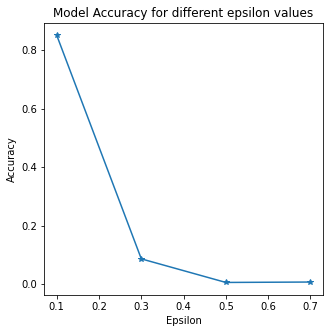

In [31]:
import seaborn as sns 
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(epsilons, accuracies, "*-")
#ax.yticks(np.arange(0, 1.1, step=0.1))
#ax.xticks(np.arange(0, .35, step=0.05))
plt.title("Model Accuracy for different epsilon values")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

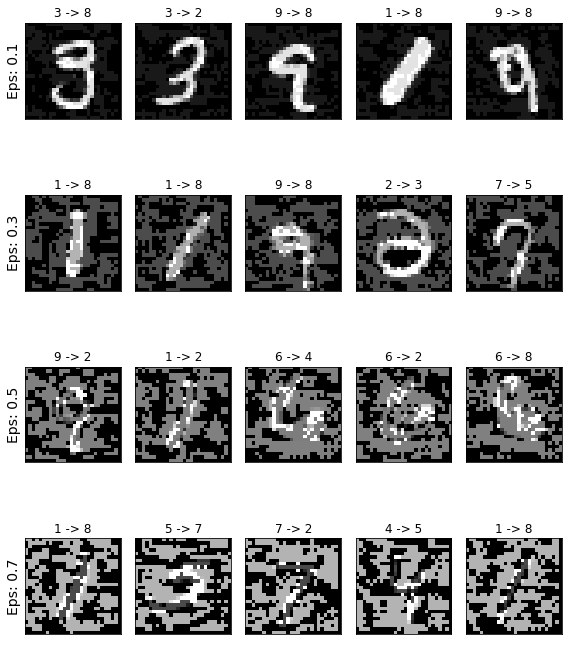

In [32]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()


**Problem :** 
* Adv exemples too different from the original output
* Can't target a specific output

## Step 2 : 
- Implement non targeted attack w pytorch 
- Implement targeted attack w pytorch